# Computational Finance Research Notebook

## Load data and Packages

In [1]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import * 

In [2]:
#Load data in for in-sample
tickers = ["TSLA", "AAPL", "AMD", '^GSPC']
start = "2011-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  4 of 4 completed


In [3]:
#Load data in for out-of-sample
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

[*********************100%***********************]  4 of 4 completed


## Stock analysis

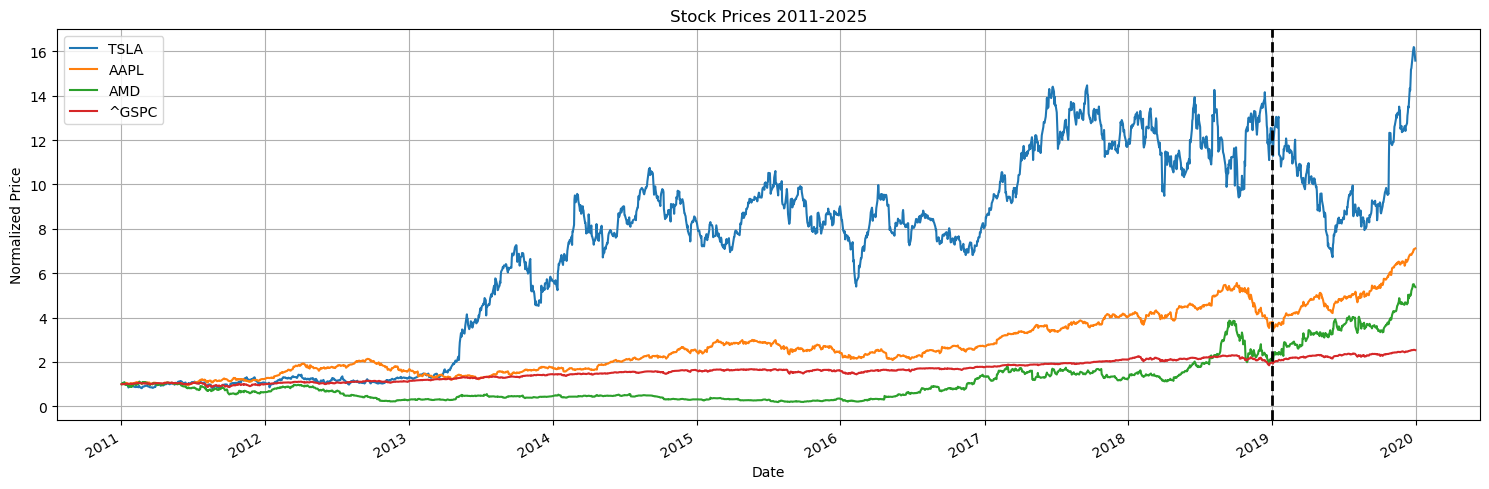

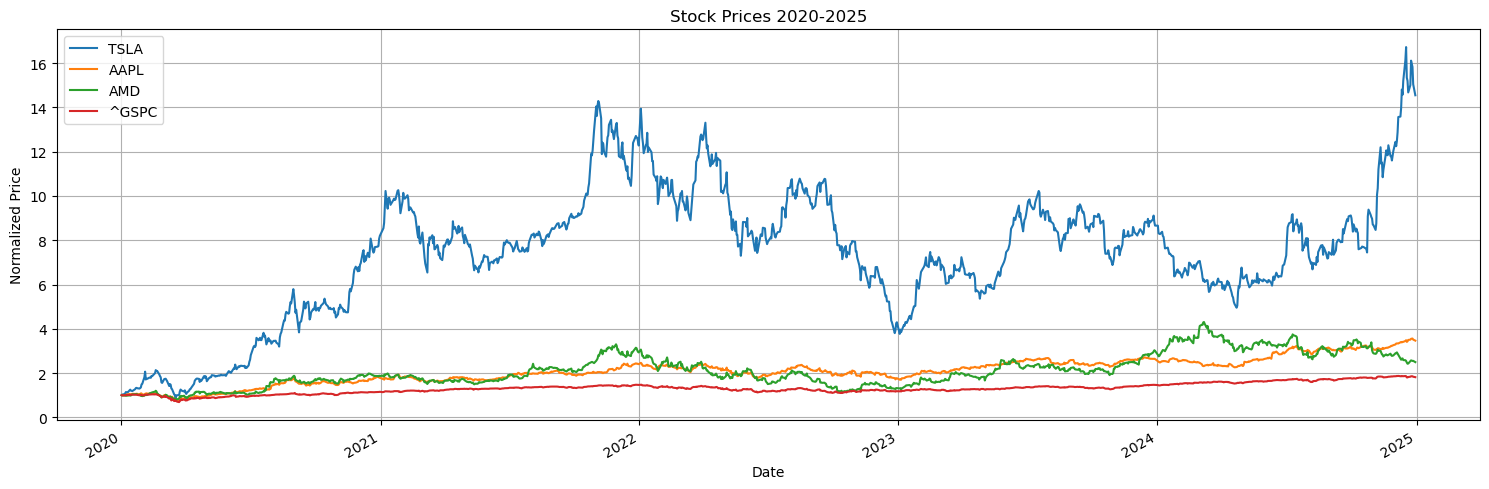

In [4]:
#Plot full data
full_df_prices = pd.concat([df_prices, test_df_prices], axis=0)
plt.figure(figsize=(15, 5))
for stock in tickers:
    (df_prices[stock] / df_prices[stock].iloc[0]).plot(label=stock)
plt.legend()
plt.axvline(x=pd.Timestamp('2019-01-01'), color='black', linestyle='--', linewidth=2, label='Sample Split')
plt.title('Stock Prices 2011-2025')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()

#Plot in sample data
plt.figure(figsize=(15, 5))
for stock in tickers:
    (test_df_prices[stock] / test_df_prices[stock].iloc[0]).plot(label=stock)
plt.legend()
plt.title('Stock Prices 2020-2025')
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()

In [5]:
#add explainations how each stock moves what pattern it shows maybe compare the period 2011-2020 to the period 2020-2025 to argue that the general movement pattern didnt change

## Signal 1: Moving Average Crossover with MACD Indicator

#### 1.A) Define signal

In [6]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig['signal'], macd_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['ma_position_change'] = ma_sig['position_change']
    signals['macd_position_change'] = macd_sig['position_change']

    return signals

#### 1.B) Gridsearch best parameters for training set

In [7]:
#Explain what parameters the literature suggest and thast why we construct the gridsearch around these parameters

In [8]:
param_grid = {
    'short_ma': [20, 30, 40, 50, 60, 70],
    'long_ma': [125, 150, 175, 200, 225, 250],
    'short_macd': [8, 12, 16],
    'long_macd': [20, 26, 32],
    'signal_window_macd': [5, 9, 13]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd     cumret  b&h cumret    sharpe  b&h sharpe
0        70      225          12         20                  13  18.520052    14.57851  0.971732    0.859448
1        60      250          12         20                  13  18.417208    14.57851  0.970274    0.859448
2        70      125          16         20                   9  17.844749    14.57851  0.966064    0.859448

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret  b&h cumret    sharpe  b&h sharpe
0        60      250          16         32                   9  5.610312    6.116216  1.111107    0.981583
1        50      225          16         32                   9  5.435539    6.116216  1.101148    0.981583
2        60      250          16         26                  13  5.348540    6.116216  1.089950    0.981583

=== Results for AMD ===
   short_ma  long_ma  short_macd  long_macd  signal_win

#### 1.C) Evaluate parameters

In [9]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal01(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,11.639303,2.061870,1.904343,1.049515
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,1.221386,1.083052,0.702678,1.058836
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,0.086577,0.137790,0.091623,0.392188
Strategy Max Drawdown,0.476396,0.310632,0.478012,0.206333
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.530543,0.232189,0.443856,0.146083
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [10]:
best_ticker = 'AAPL' #Change this depending on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 1 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 1 / AAPL combination ===
{'short_ma': 60, 'long_ma': 250, 'short_macd': 16, 'long_macd': 32, 'signal_window_macd': 9}


#### 1.D) Analysis of individual subsignals

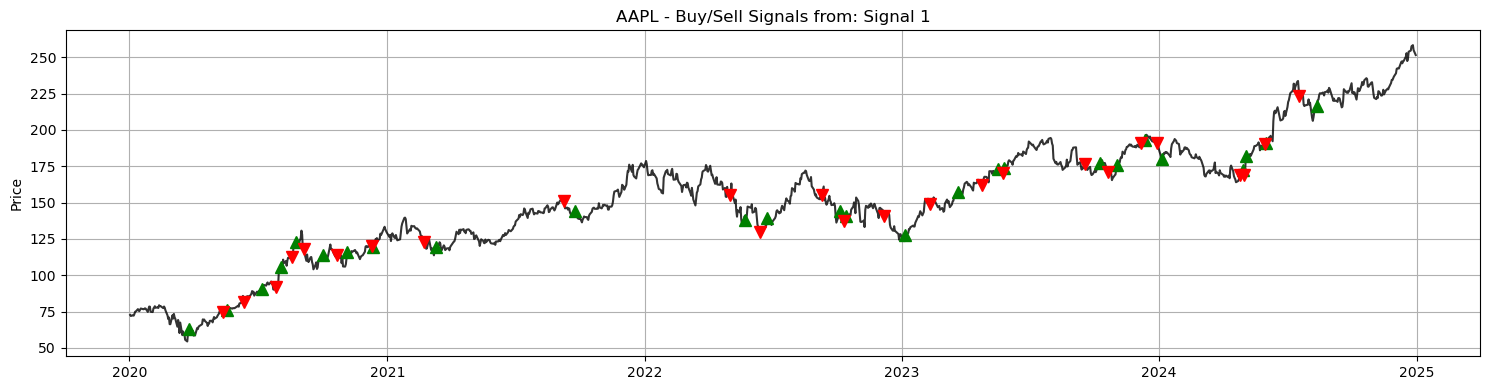

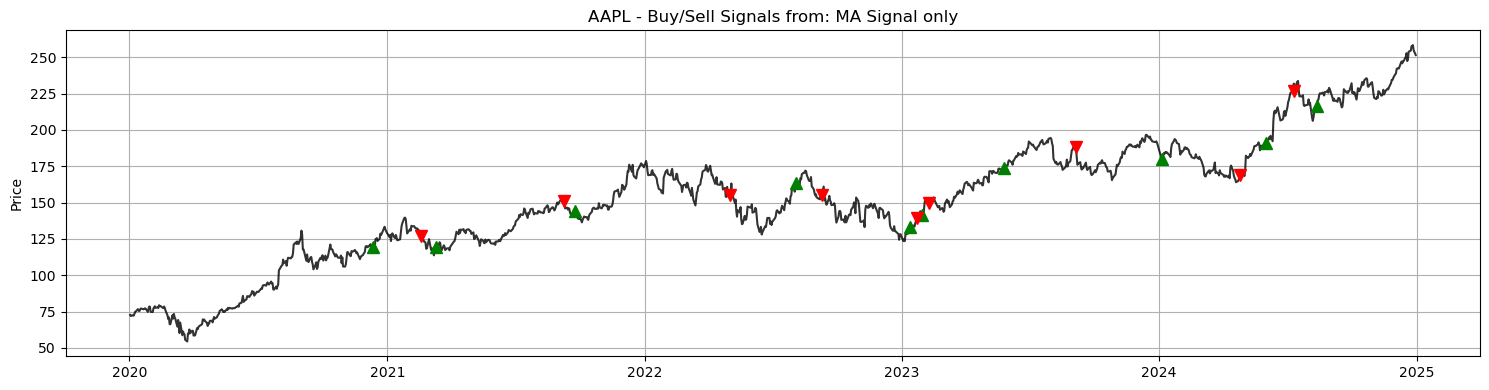

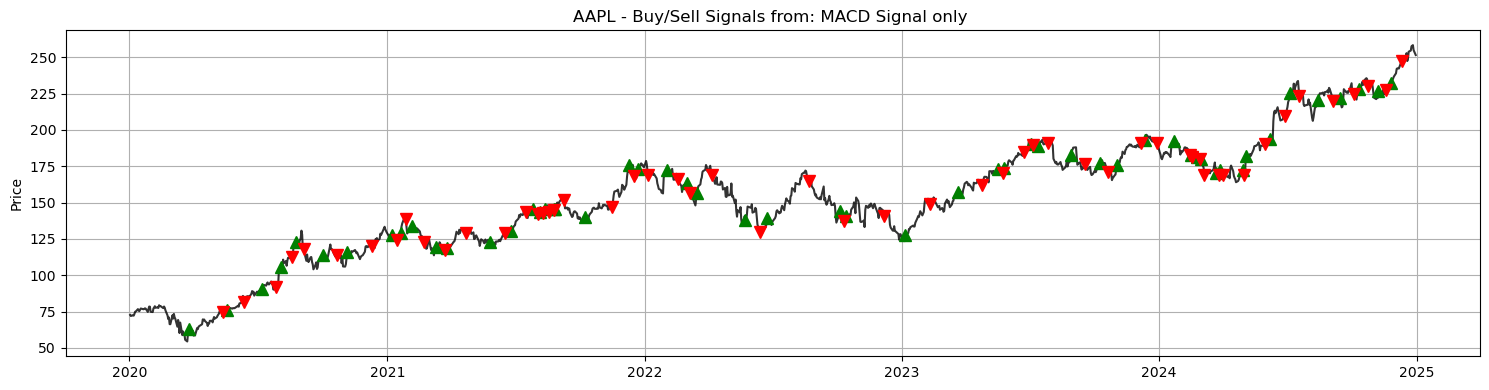

In [11]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 1')
plot_buy_and_sell_signals(signal['ma_position_change'], test_df_prices, best_ticker, 'MA Signal only')
plot_buy_and_sell_signals(signal['macd_position_change'], test_df_prices, best_ticker, 'MACD Signal only ')

In [12]:
# Compare sub signals return

## Signal 2: RSI with Bollinger Bands

#### 2.A) Define signal

In [13]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig= signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig['signal'], bollinger_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['rsi_position_change'] = rsi_sig['position_change']
    signals['bollinger_position_change'] = bollinger_sig['position_change']

    return signals

#### 2.B) Gridsearch best parameters for training set

In [28]:
param_grid = {
    'rsi_window_length': [10, 12, 14, 16, 18],
    'lower_rsi_bound': [20, 25, 30, 35, 40],
    'upper_rsi_bound': [60, 65, 70, 75, 80],
    'bollinger_window_length': [10, 12, 14, 16, 18],
    'bollinger_n_stds': [1, 2]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds       cumret  b&h cumret    sharpe  b&h sharpe
0                 16               25               70                       10                 1  8761.663982    14.57851  3.298772    0.859448
1                 18               25               65                       10                 1  8761.663982    14.57851  3.298772    0.859448
2                 18               25               60                       10                 1  8761.663982    14.57851  3.298772    0.859448

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds     cumret  b&h cumret    sharpe  b&h sharpe
0                 14               20               80                       10                 1  89.400541    6.116216  2.992565    0.981583
1                 18               20               75                       10   

#### 2.C) Evaluate parameters on test set

In [29]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal02(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,166.015983,23.621195,96.360622,5.242617
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,2.300928,2.861952,2.671883,3.099904
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,1.166120,1.916690,2.060828,2.433256
Strategy Max Drawdown,0.518052,0.213675,0.227500,0.052038
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.500489,0.234371,0.369533,0.120971
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [25]:
best_ticker = 'AMD' #Change this depending on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 2 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 2 / AMD combination ===
{'adx_window_length': 10, 'adx_threshhold': 22, 'donchian_window_length': 10}


#### 2.D) Analysis and interpretation

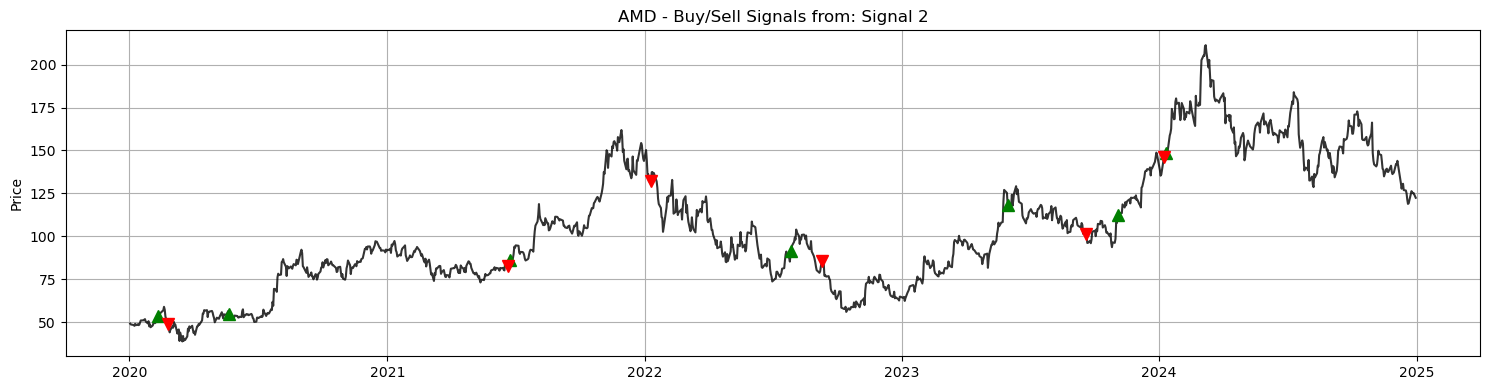

KeyError: 'rsi_position_change'

In [26]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 2')
plot_buy_and_sell_signals(signal['rsi_position_change'], test_df_prices, best_ticker, 'RSI Signal')
plot_buy_and_sell_signals(signal['bollinger_position_change'], test_df_prices, best_ticker, 'Bollinger Signal')

## Signal 3: Donchian Channel with ADX

#### 3.A) Define signal

In [18]:
def signal03(prices, adx_window_length, adx_threshhold, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig = donchian_signals(prices, donchian_window_length)
    donchian_sig_array = np.asarray(donchian_sig['signal'])

    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and donchian_sig_array[i] == 1 and adx[i] > adx_threshhold:
            holding = 1
        elif holding == 1 and donchian_sig_array[i] == 0 and adx[i] > adx_threshhold:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['donchian_position_change'] = donchian_sig['position_change']
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### 3.B) Gridsearch best Parameters

In [19]:
param_grid = {
    'adx_window_length': [10, 12, 14, 16, 18, 20],
    'adx_threshhold': [20, 22, 25, 26, 28, 30],
    'donchian_window_length': [10, 12, 14, 16, 18, 20],
    
}

all_best_params = {}
for ticker in tickers:
    prices = test_df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   adx_window_length  adx_threshhold  donchian_window_length     cumret  b&h cumret    sharpe  b&h sharpe
0                 12              22                      10  38.195686   13.552015  1.907435    1.134808
1                 10              22                      10  40.477675   13.552015  1.894104    1.134808
2                 10              20                      10  37.410402   13.552015  1.853967    1.134808

=== Results for AAPL ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                 12              22                      10  3.424081    2.464475  1.686374    0.945262
1                 14              20                      10  3.188249    2.464475  1.678080    0.945262
2                 12              22                      12  3.085437    2.464475  1.664868    0.945262

=== Results for AMD ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cum

#### 3.C) Evaluate parameters on test set

In [20]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal03(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD,^GSPC
Strategy Cumulative Return,38.195686,3.424081,4.529146,1.159615
BuyHold Cumulative Return,13.552015,2.464475,1.493686,0.813140
Strategy Sharpe,1.907435,1.686374,1.134222,1.404328
BuyHold Sharpe,1.134808,0.945262,0.611055,0.666648
Sharpe Delta,0.772626,0.741112,0.523167,0.737680
Strategy Max Drawdown,0.337354,0.162422,0.286481,0.096045
BuyHold Max Drawdown,0.736322,0.314273,0.654499,0.339250
Strategy Volatility,0.435846,0.187429,0.358379,0.114736
BuyHold Volatility,0.671894,0.316891,0.524764,0.213473


In [21]:
best_ticker = 'AMD' #Change this depending on what tikcer works best with the signal
print(f"\n=== Best parameters for Signal 3 / {best_ticker} combination ===")
print(all_best_params[best_ticker])


=== Best parameters for Signal 3 / AMD combination ===
{'adx_window_length': 10, 'adx_threshhold': 22, 'donchian_window_length': 10}


#### 3.D) Analyisis and interpretation

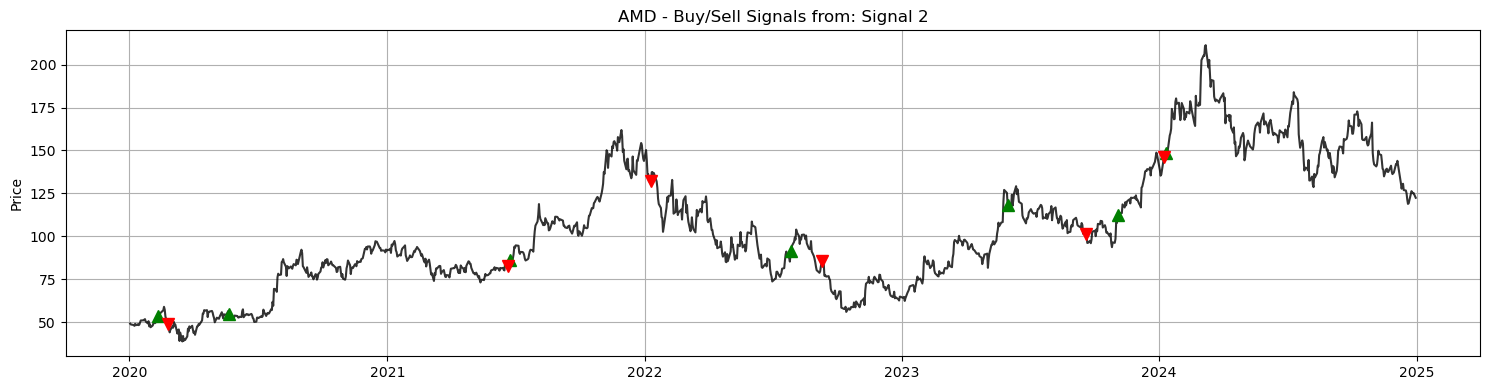

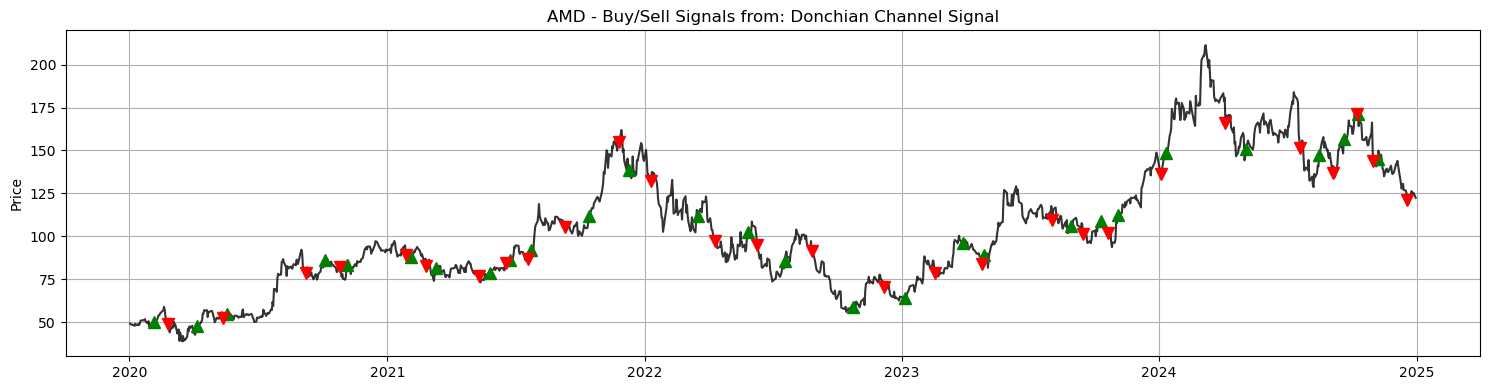

In [22]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, best_ticker, 'Signal 2')
plot_buy_and_sell_signals(signal['donchian_position_change'], test_df_prices, best_ticker, 'Donchian Channel Signal')